# **D208 Performance Assessment 2:** Logistic Regression  

**Student:** Chris Fischer  
**ID:** 011933891  
**Dataset:** Medical  
---

### *Research Question*  

Which demographic and medical factors predict the likelihood that a patient will be readmitted?

## Initialization
---

In [27]:
#import needed libraries
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tabulate import tabulate  

#allow pd.describe to show all columns of the data frame [In-Text Citation: (Ray, 2020)]
pd.options.display.max_columns = None 

#Initialize some lists
survey_answers = [1,2,3,4,5,6,7,8]
group_names = ['True Neg','False Pos','False Neg','True Pos']

# Starting explanatory variables
numerical_variables = ['VitD_levels','Doc_visits','Full_meals_eaten','vitD_supp','Income','Population','Age','Children','Initial_days']
categorical_variables = ['Initial_admin','Complication_risk','Marital','Gender','Services','Area','State']
yes_no_variables = ['Soft_drink','HighBlood','Stroke','Overweight','Hyperlipidemia','BackPain','Anxiety','Allergic_rhinitis','Reflux_esophagitis','Asthma','Diabetes']
X_full = numerical_variables + categorical_variables + yes_no_variables
X_reduced = []

#  Dependent variable
y = 'ReAdmis'
y_list = [y]

#load church_missing_data.csv
df = pd.read_csv('medical_clean.csv', keep_default_na=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CaseOrder           10000 non-null  int64  
 1   Customer_id         10000 non-null  object 
 2   Interaction         10000 non-null  object 
 3   UID                 10000 non-null  object 
 4   City                10000 non-null  object 
 5   State               10000 non-null  object 
 6   County              10000 non-null  object 
 7   Zip                 10000 non-null  int64  
 8   Lat                 10000 non-null  float64
 9   Lng                 10000 non-null  float64
 10  Population          10000 non-null  int64  
 11  Area                10000 non-null  object 
 12  TimeZone            10000 non-null  object 
 13  Job                 10000 non-null  object 
 14  Children            10000 non-null  int64  
 15  Age                 10000 non-null  int64  
 16  Incom

## Cleaning
---

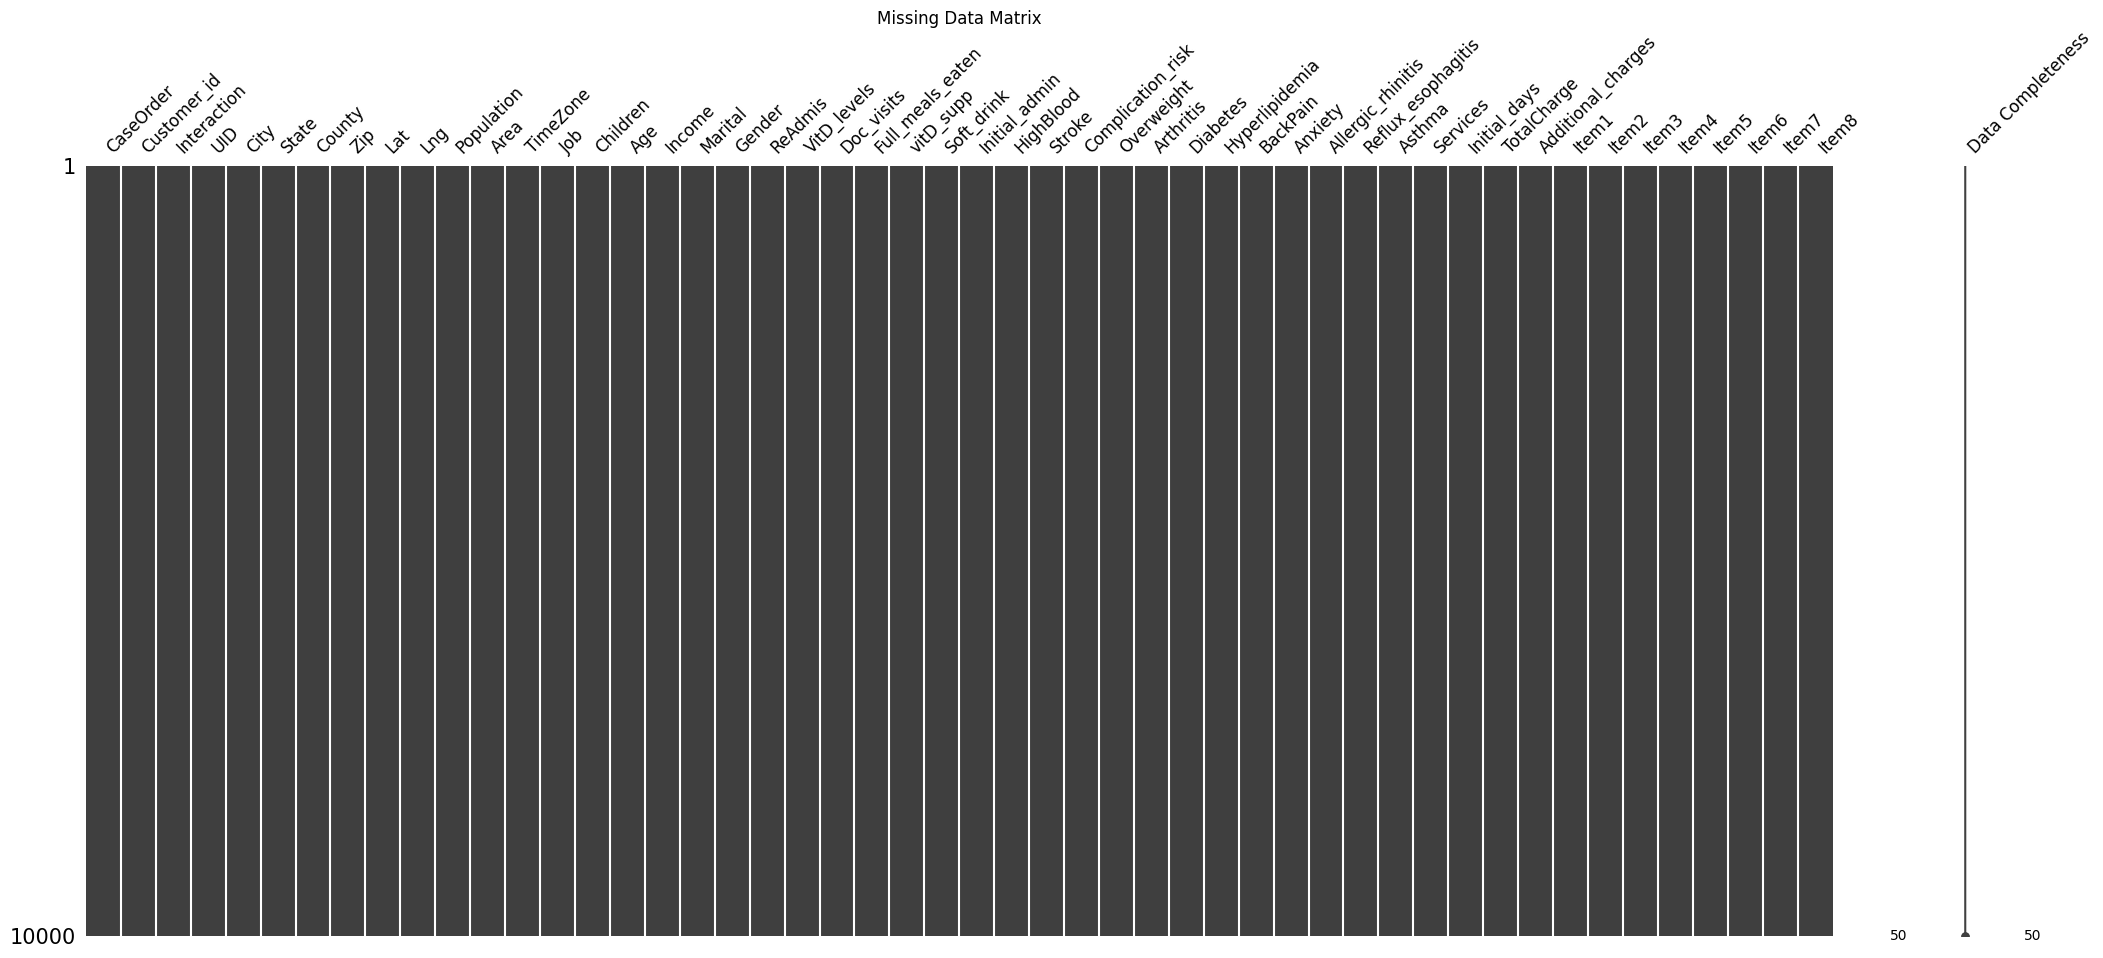

In [28]:
# Check missing data
msno.matrix(df, fontsize = 12, labels=True)
plt.title('Missing Data Matrix')
plt.show()

In [29]:
#Check values in yes/no variables
print(df[yes_no_variables][~df[yes_no_variables].isin(['Yes','No'])].count())


Soft_drink            0
HighBlood             0
Stroke                0
Overweight            0
Hyperlipidemia        0
BackPain              0
Anxiety               0
Allergic_rhinitis     0
Reflux_esophagitis    0
Asthma                0
Diabetes              0
dtype: int64


In [30]:
#Detect potential outliers
df_z = (df[numerical_variables] - df[numerical_variables].mean())/df[numerical_variables].std(ddof=0)
outlier_cols = df_z.loc[: , (df_z > 3.0).any()].columns
for col in outlier_cols :
    cnt = len(df_z[df_z[col]>3])
    min, max = df[col].min(), df[col].max()
    print('Likely outlier for {0:<20}\t Count: {1:7d} ({2:5.2%} of observations)\tMin: {3:>9.2f}\tMax: {4:>9.2f}'.format(col,cnt,cnt/10000,min,max))

Likely outlier for VitD_levels         	 Count:      14 (0.14% of observations)	Min:      9.81	Max:     26.39
Likely outlier for Doc_visits          	 Count:       2 (0.02% of observations)	Min:      1.00	Max:      9.00
Likely outlier for Full_meals_eaten    	 Count:      33 (0.33% of observations)	Min:      0.00	Max:      7.00
Likely outlier for vitD_supp           	 Count:      70 (0.70% of observations)	Min:      0.00	Max:      5.00
Likely outlier for Income              	 Count:     143 (1.43% of observations)	Min:    154.08	Max: 207249.10
Likely outlier for Population          	 Count:     218 (2.18% of observations)	Min:      0.00	Max: 122814.00
Likely outlier for Children            	 Count:     202 (2.02% of observations)	Min:      0.00	Max:     10.00


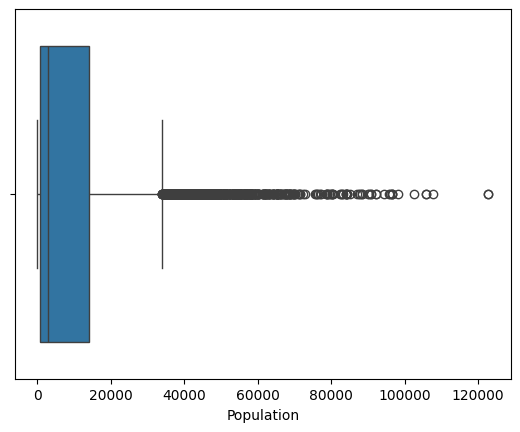

Population
0        109
195       14
115       11
178       11
285       11
        ... 
8092       1
11147      1
27175      1
7371       1
41524      1
Name: count, Length: 5951, dtype: int64


In [31]:
# Deeper look at Population
sns.boxplot(data=df, x='Population')
plt.show()
print(df['Population'].value_counts())

In [32]:
# Drop rows with Population <= 0
df = df[df.Population > 0]
df['Population'].count()

9891

## Summary Statistics
---

In [33]:
# Dependent variable
col = y
print(df[col].value_counts())
print(f'Mode: {df[col].mode()[0]}\n')

ReAdmis
No     6262
Yes    3629
Name: count, dtype: int64
Mode: No



In [34]:
# Independent numerical variables
for col in numerical_variables :
    print(f'{col} :')
    print(df[col].describe())

VitD_levels :
count    9891.000000
mean       17.966051
std         2.017781
min         9.806483
25%        16.629179
50%        17.952513
75%        19.352843
max        26.394449
Name: VitD_levels, dtype: float64
Doc_visits :
count    9891.000000
mean        5.012537
std         1.046176
min         1.000000
25%         4.000000
50%         5.000000
75%         6.000000
max         9.000000
Name: Doc_visits, dtype: float64
Full_meals_eaten :
count    9891.000000
mean        1.000506
std         1.008006
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         7.000000
Name: Full_meals_eaten, dtype: float64
vitD_supp :
count    9891.000000
mean        0.398847
std         0.628892
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         5.000000
Name: vitD_supp, dtype: float64
Income :
count      9891.000000
mean      40484.044689
std       28511.621864
min         154.080000
25%       19609.470000
50%     

In [35]:
# Independent categorical variables
for col in categorical_variables+yes_no_variables :
    df[col] = df[col].replace('\s+', '',regex=True)
    print(df[col].value_counts())
    print(f'Mode: {df[col].mode(0)[0]}\n')

Initial_admin
EmergencyAdmission      5014
ElectiveAdmission       2475
ObservationAdmission    2402
Name: count, dtype: int64
Mode: EmergencyAdmission

Complication_risk
Medium    4461
High      3324
Low       2106
Name: count, dtype: int64
Mode: Medium

Marital
Widowed         2016
Married         1998
Separated       1968
NeverMarried    1961
Divorced        1948
Name: count, dtype: int64
Mode: Widowed

Gender
Female       4969
Male         4710
Nonbinary     212
Name: count, dtype: int64
Mode: Female

Services
BloodWork      5215
Intravenous    3091
CTScan         1210
MRI             375
Name: count, dtype: int64
Mode: BloodWork

Area
Rural       3330
Suburban    3291
Urban       3270
Name: count, dtype: int64
Mode: Rural

State
TX    549
PA    543
CA    538
NY    505
IL    442
OH    380
MO    325
FL    302
VA    286
IA    275
MI    267
MN    265
NC    252
GA    244
KS    218
WI    214
KY    209
WV    207
OK    206
IN    195
TN    194
AL    191
AR    187
WA    187
NE    185
NJ    

## Visualizations
---

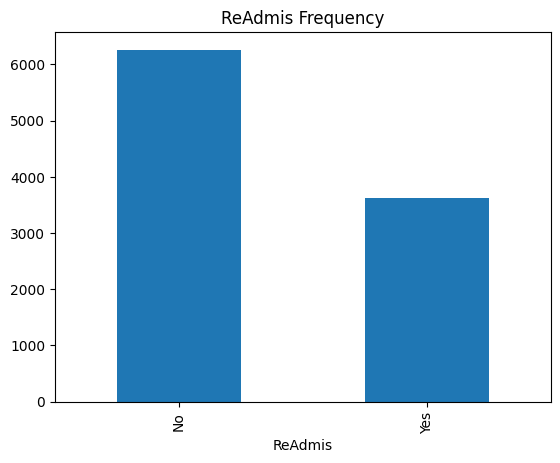

In [36]:
# Dependent variable
df[y].value_counts().sort_index().plot(kind='bar')
#plt.xlabel('Bandwidth per Year (GB)')
#plt.ylabel('n Observations')
plt.title('ReAdmis Frequency')
plt.show()

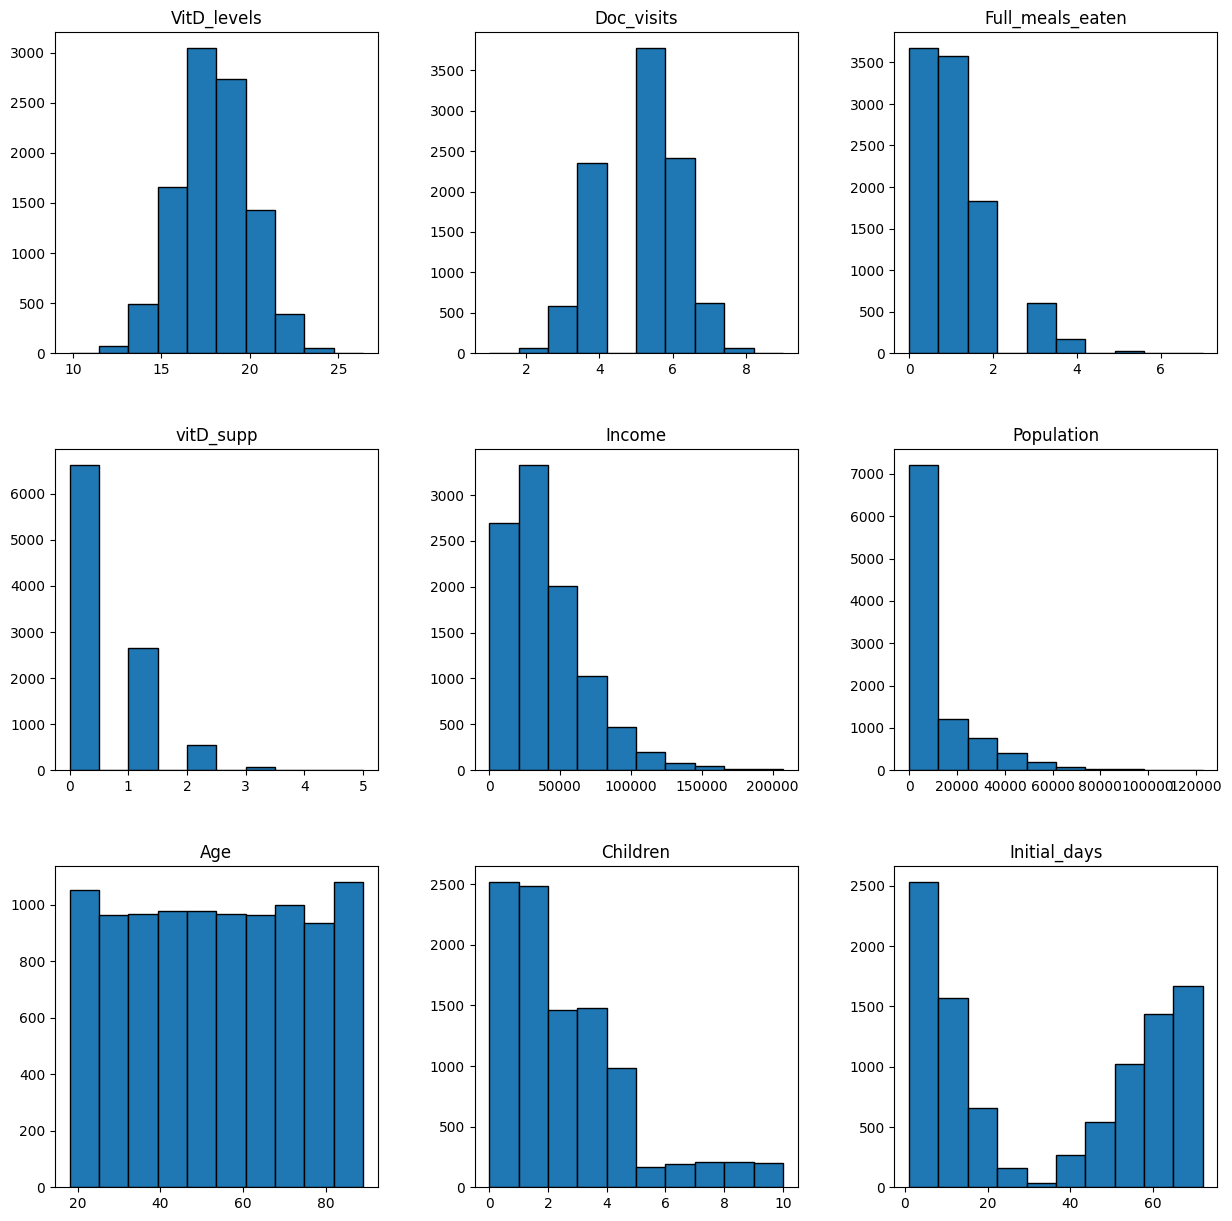

In [37]:
# Independent numeric variables univariate
df.hist(numerical_variables, grid=False, edgecolor='black', figsize=(15,15))
plt.show()

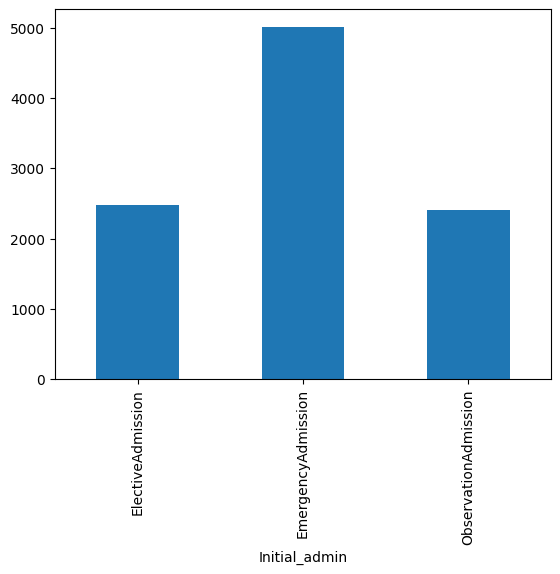

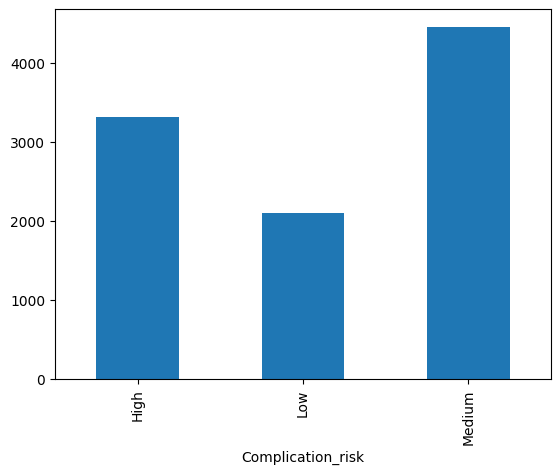

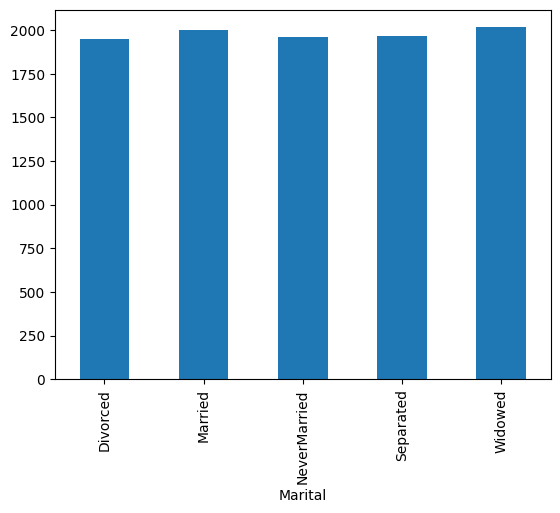

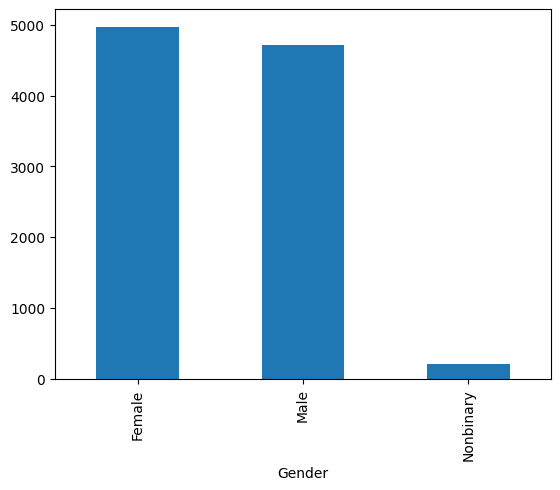

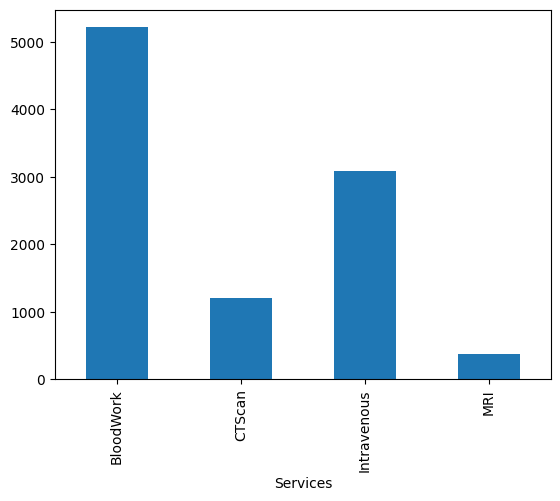

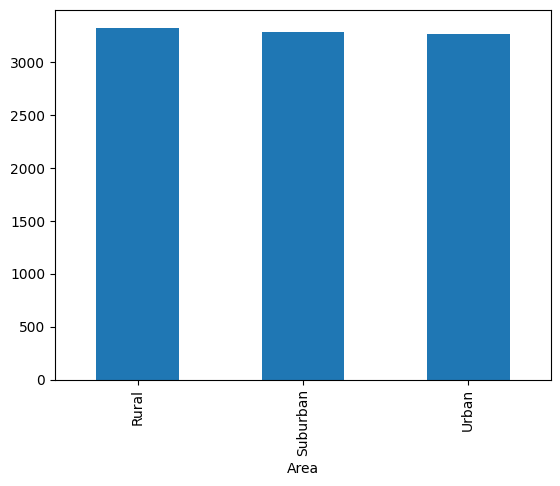

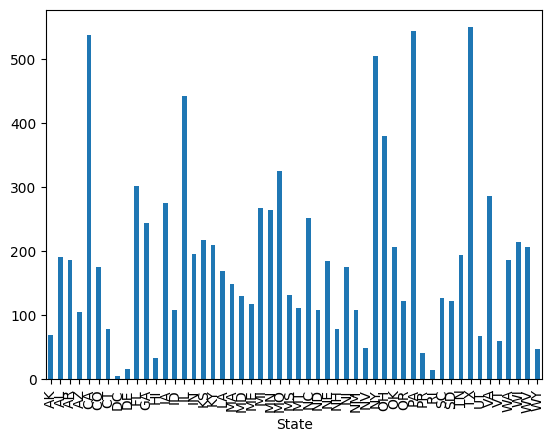

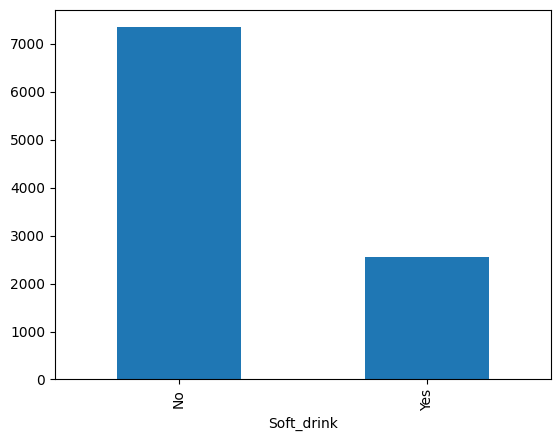

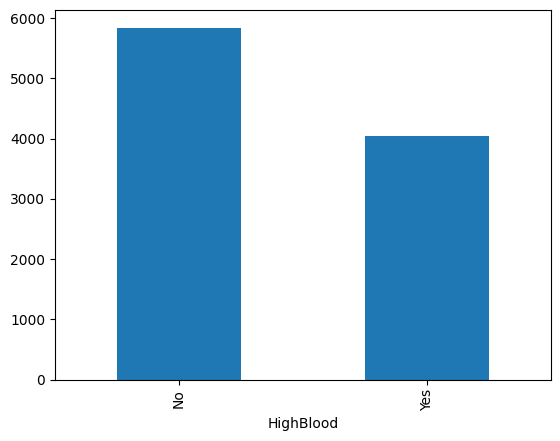

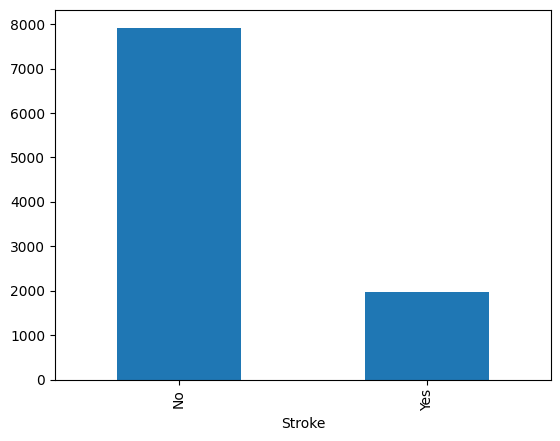

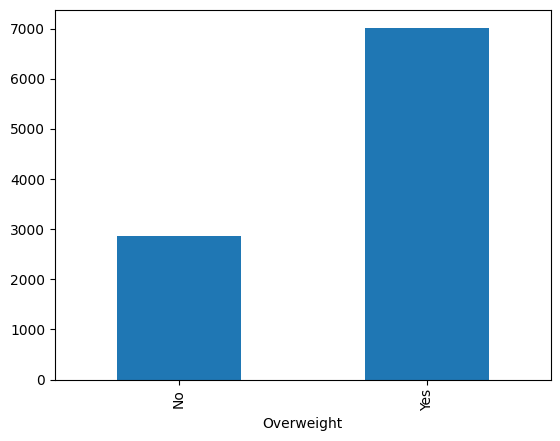

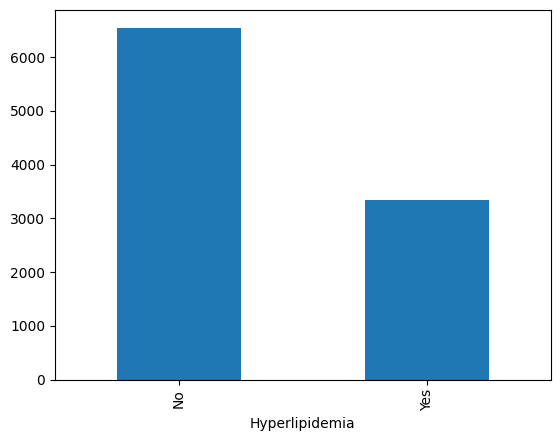

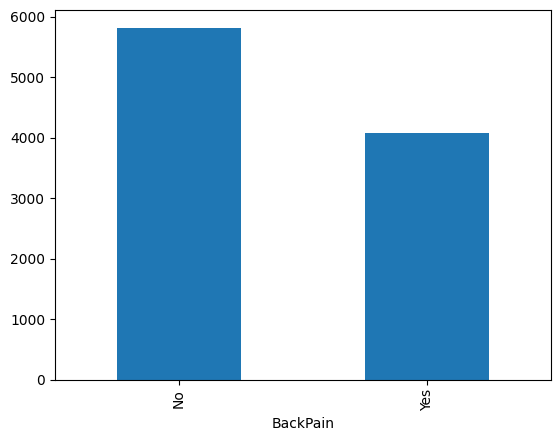

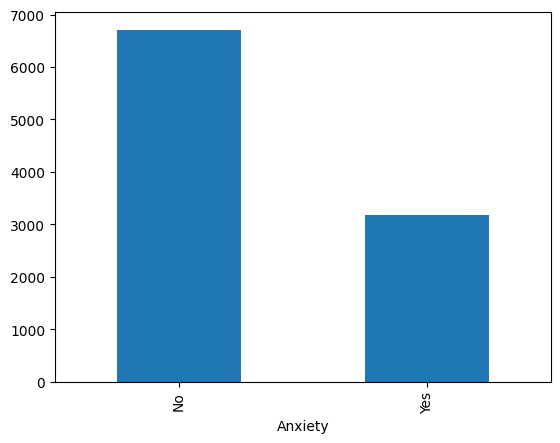

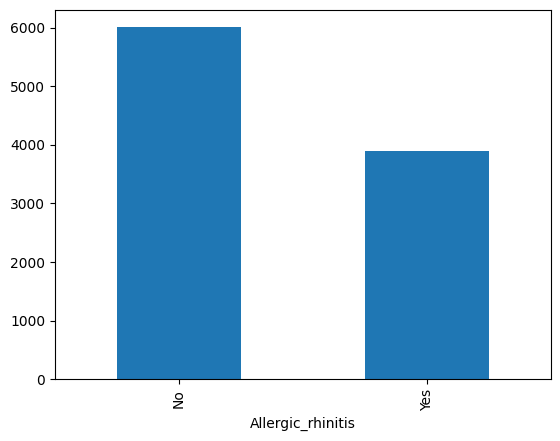

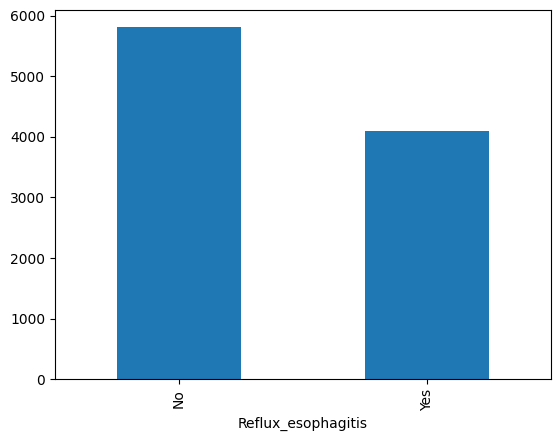

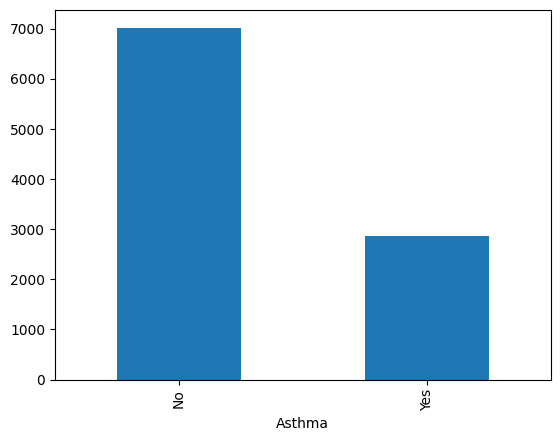

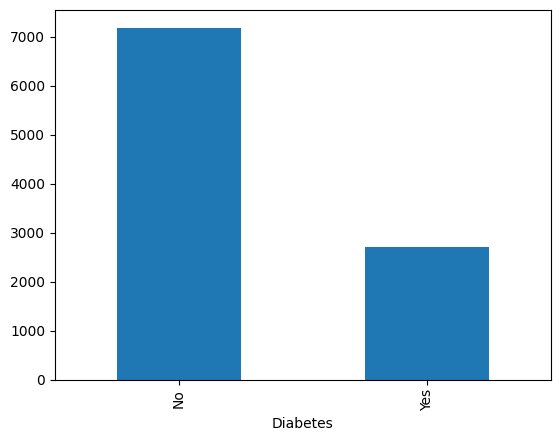

In [38]:
# Independent categorical variables univariate
for col in categorical_variables+yes_no_variables :
    df[col].value_counts().sort_index().plot(kind='bar')
    plt.show()

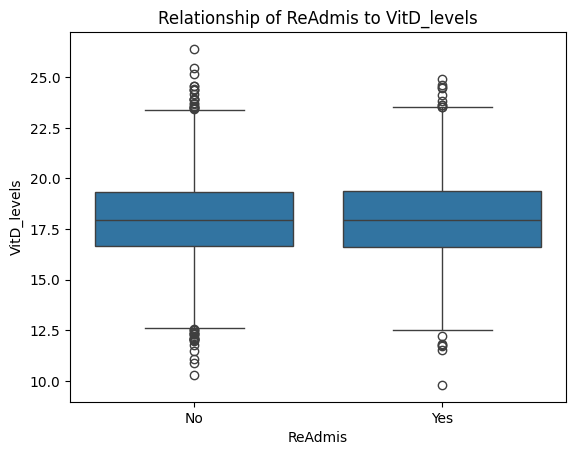

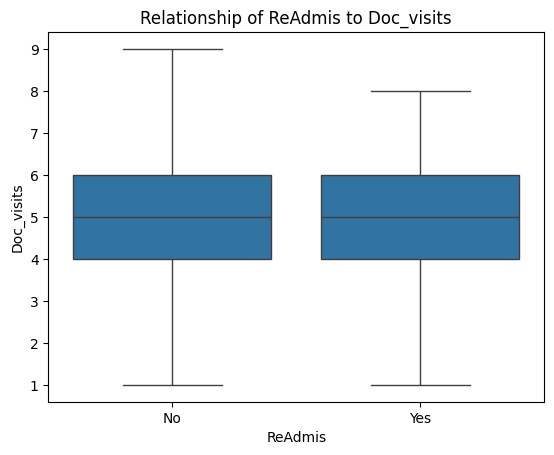

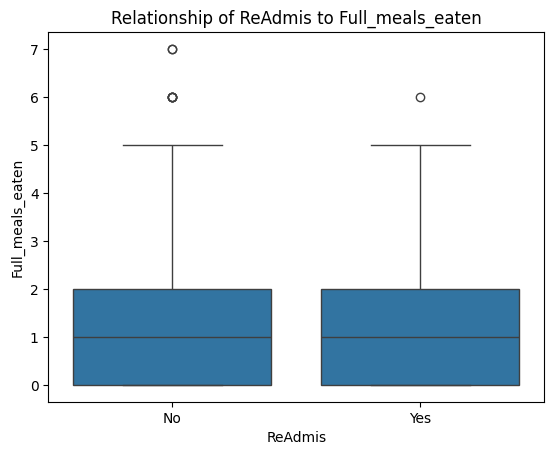

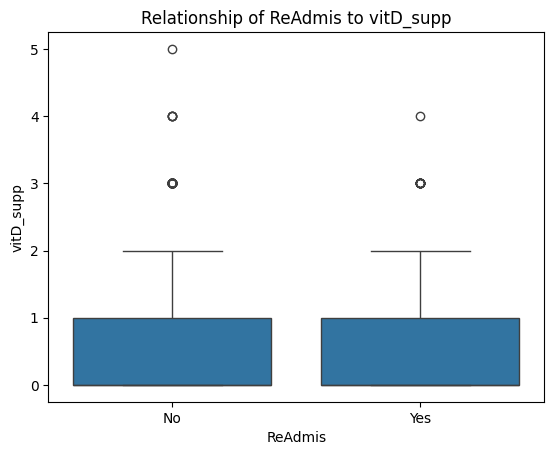

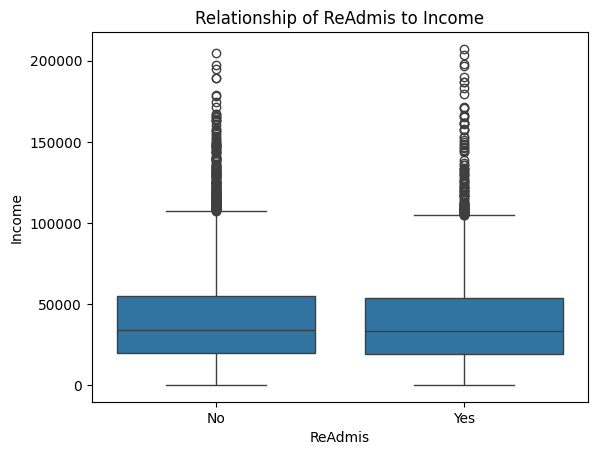

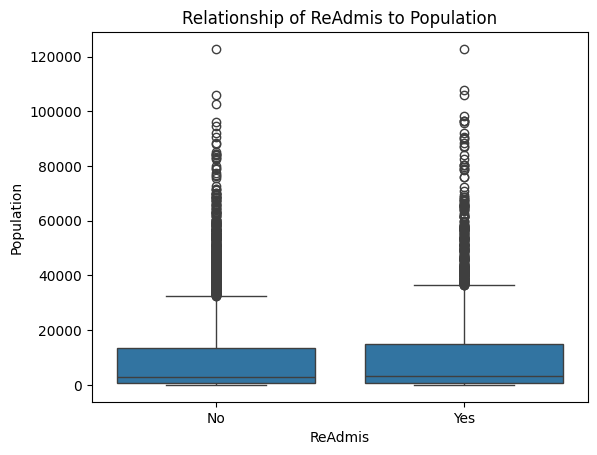

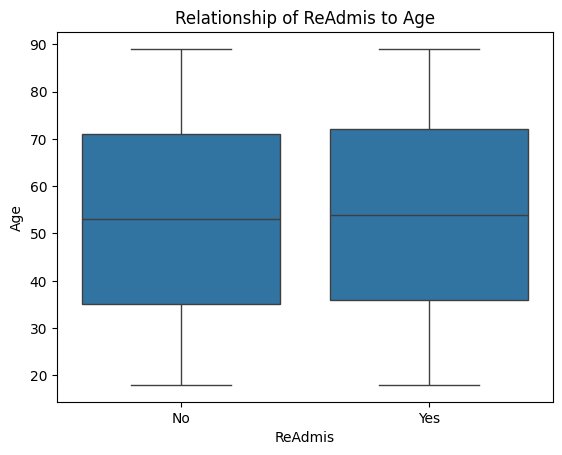

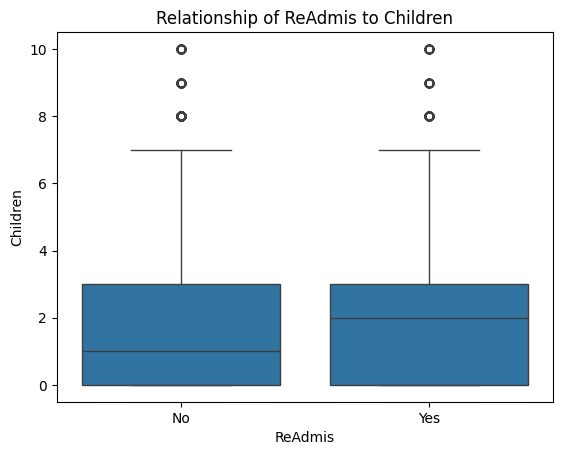

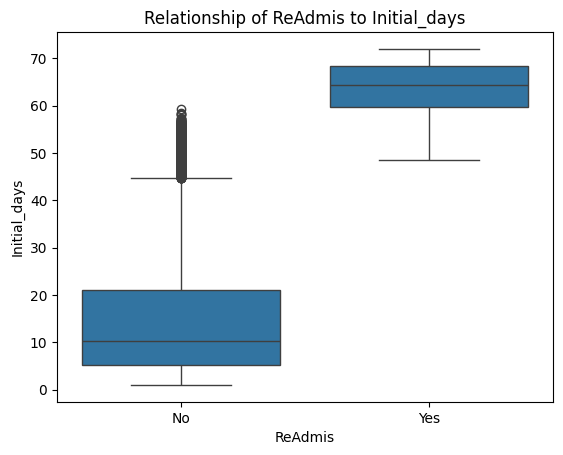

In [39]:
# Bivariate numerical
for col in numerical_variables :
    sns.boxplot(data=df, x=y, y=col)
    plt.title(f'Relationship of {y} to {col}')
    plt.show()

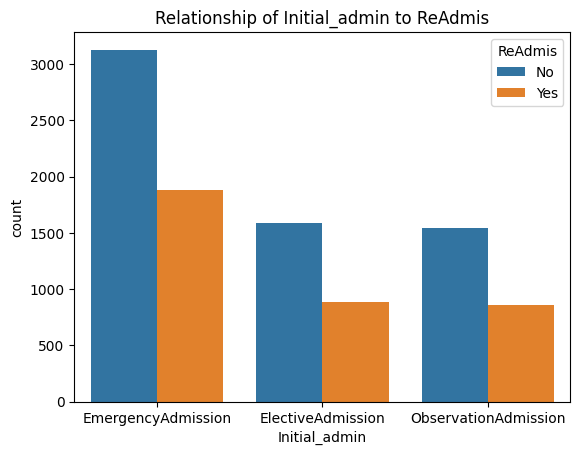

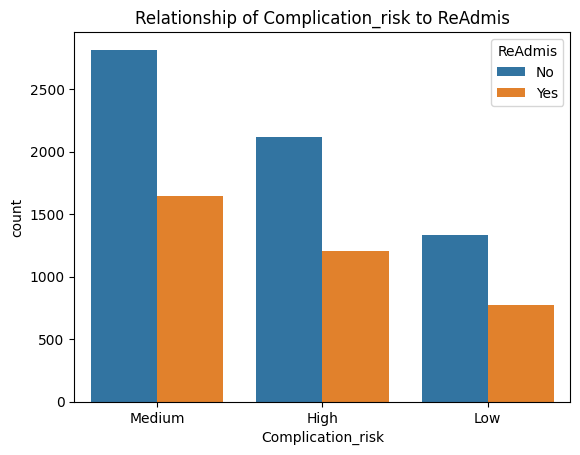

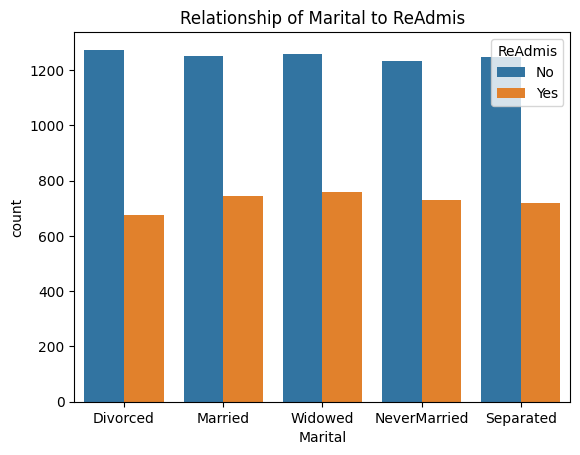

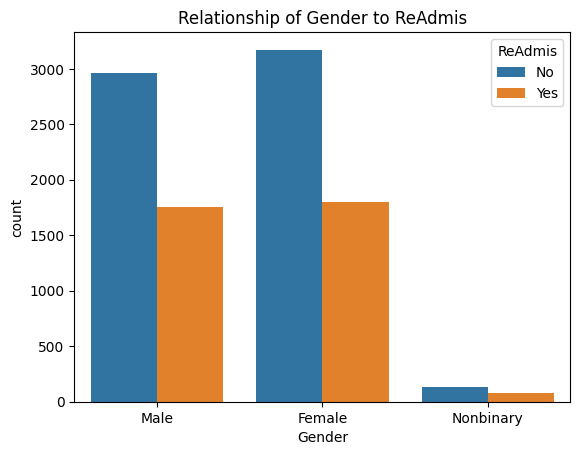

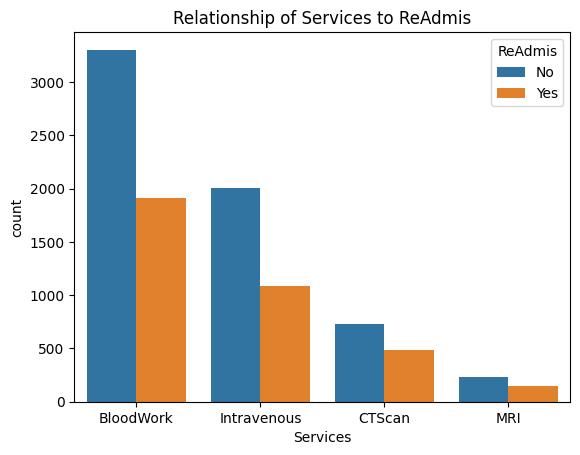

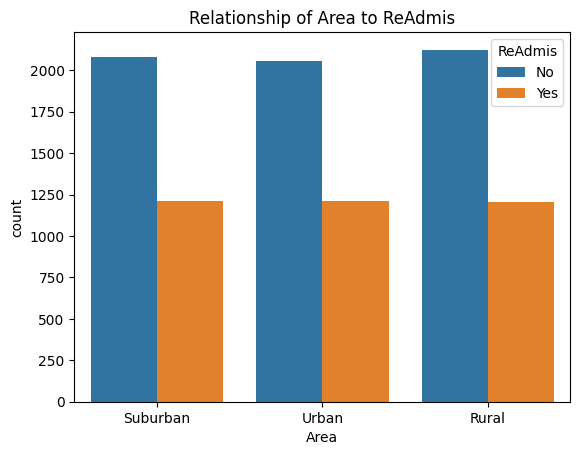

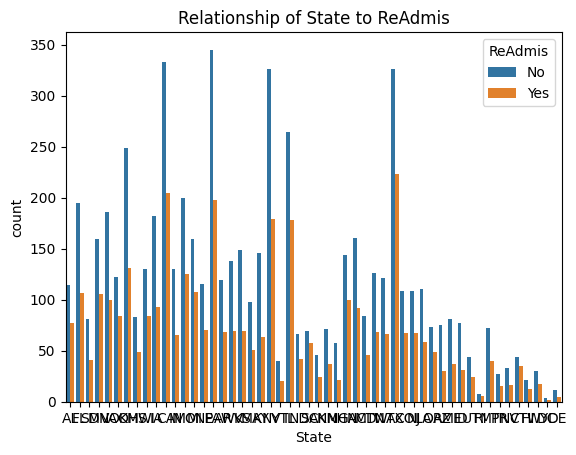

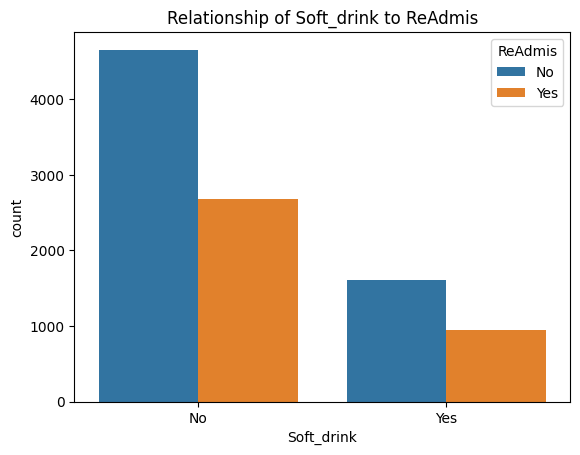

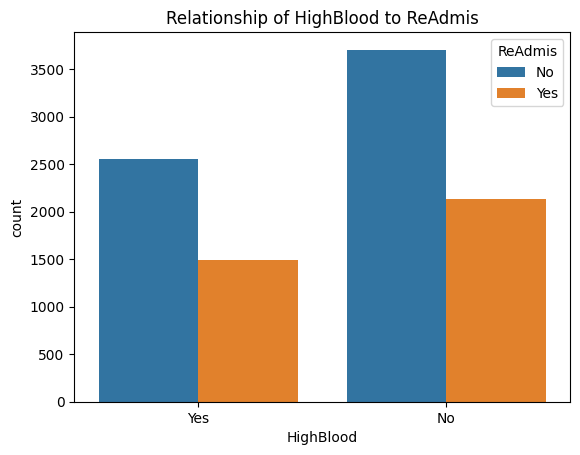

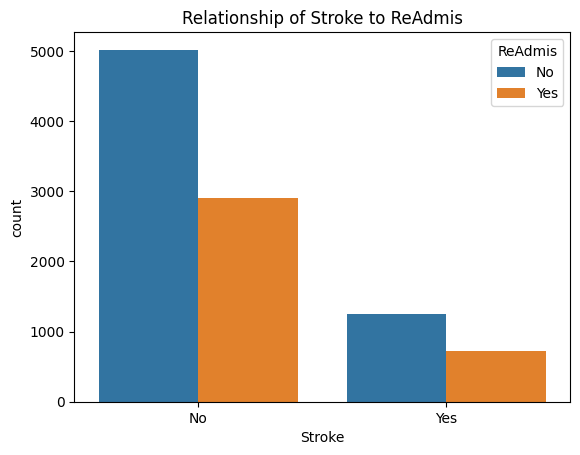

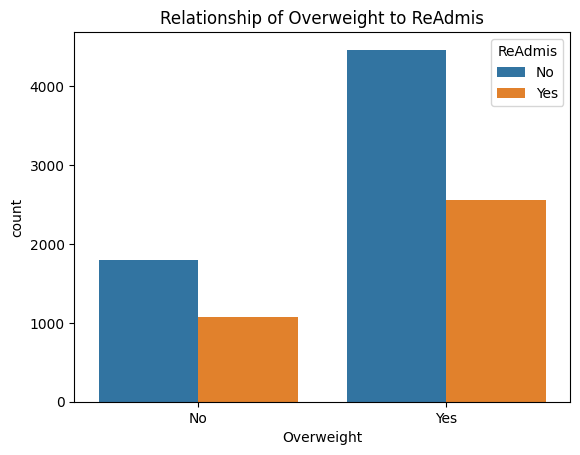

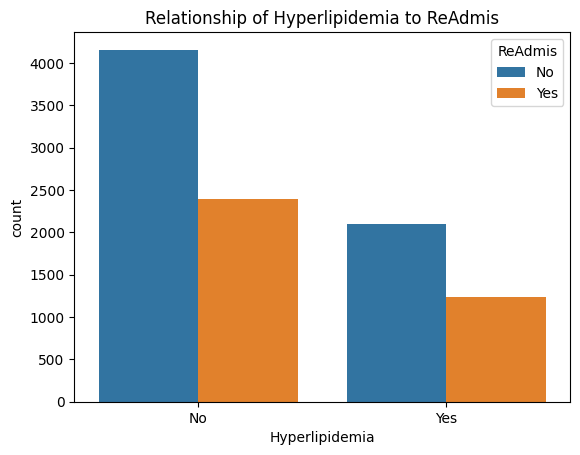

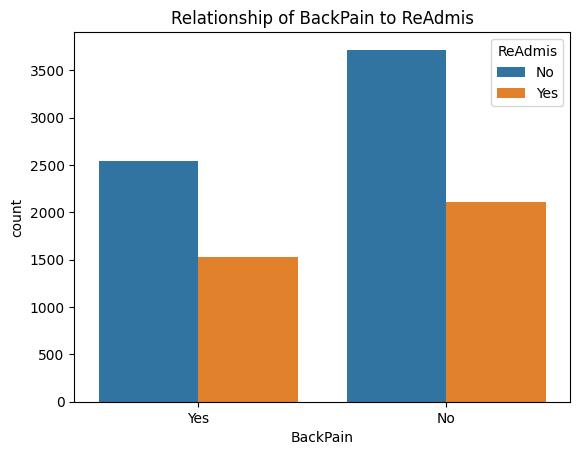

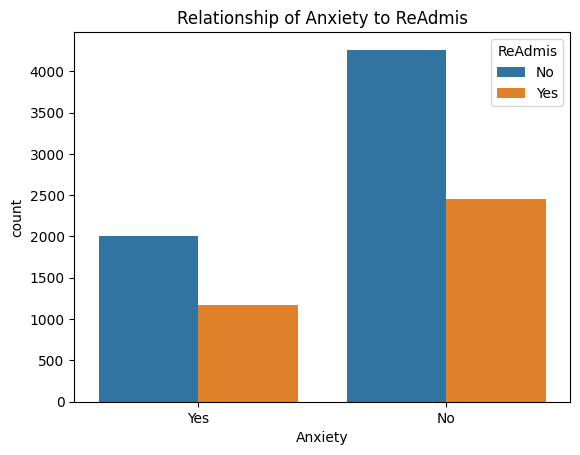

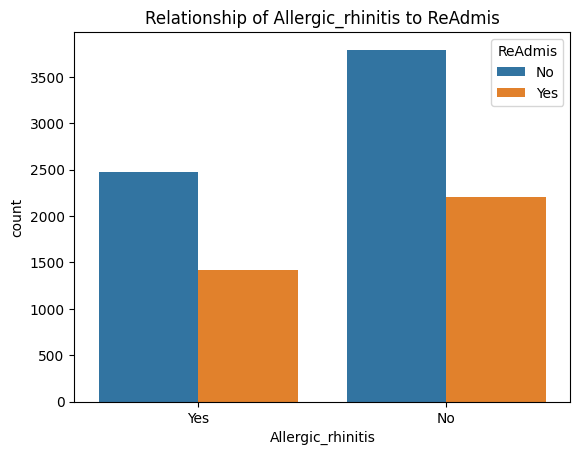

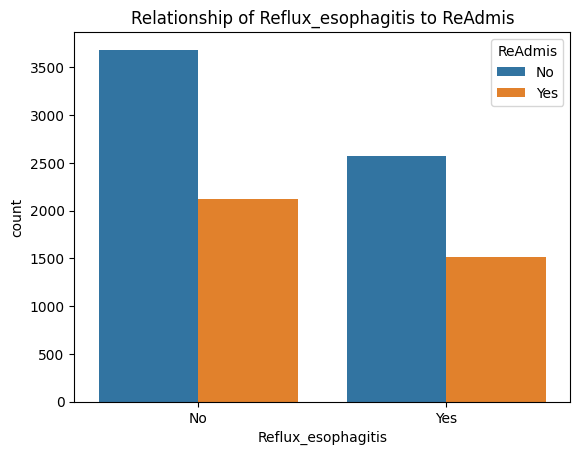

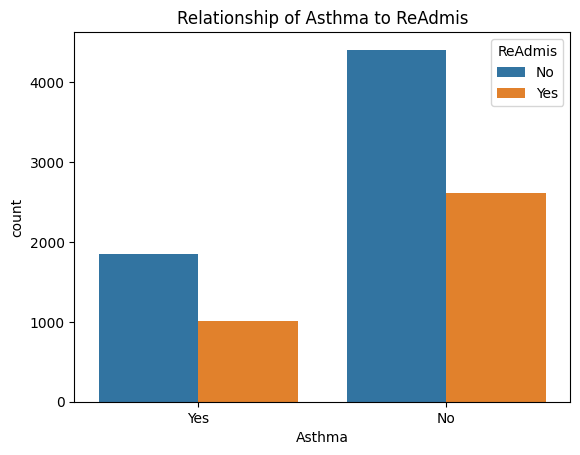

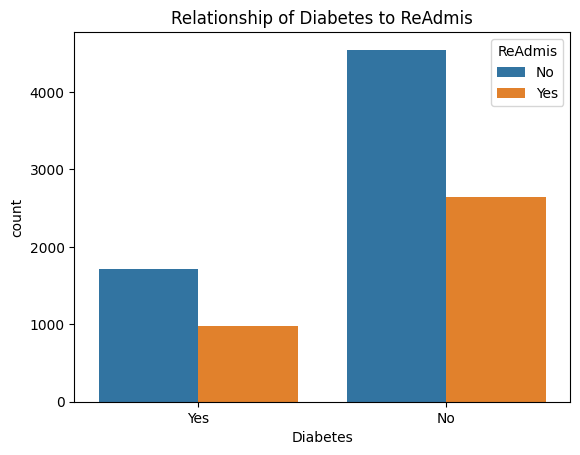

In [40]:
# Bivariate categorical
for col in categorical_variables+yes_no_variables :
    sns.countplot(data=df, x=col, hue=y)
    plt.title(f'Relationship of {col} to {y}')
    plt.show()

## Transformation
---

In [41]:
# Reexpress yes/no columns as numbers [In-Text Citation:(Eiler, 2017)]
yesno_dict = {'No': 0, 'Yes': 1}
variables = yes_no_variables + [y]
for col in variables:
    df[col] = df[col].map(yesno_dict)
print(df[variables].info())

<class 'pandas.core.frame.DataFrame'>
Index: 9891 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Soft_drink          9891 non-null   int64
 1   HighBlood           9891 non-null   int64
 2   Stroke              9891 non-null   int64
 3   Overweight          9891 non-null   int64
 4   Hyperlipidemia      9891 non-null   int64
 5   BackPain            9891 non-null   int64
 6   Anxiety             9891 non-null   int64
 7   Allergic_rhinitis   9891 non-null   int64
 8   Reflux_esophagitis  9891 non-null   int64
 9   Asthma              9891 non-null   int64
 10  Diabetes            9891 non-null   int64
 11  ReAdmis             9891 non-null   int64
dtypes: int64(12)
memory usage: 1004.6 KB
None


In [42]:
# Rexpress State with frequency encoding
df['State'] = df['State'].map(df['State'].value_counts().to_dict())
print(df['State'].info())

# Rexpress Complication_risk with simple ordinal encoding
complication_map = {'Low': 1, 'Medium': 2, 'High' : 3}
df['Complication_risk'] = df['Complication_risk'].map(complication_map)
print(df['Complication_risk'].info())

# Rexpress Area with simple ordinal encoding
area_map = {'Rural': 1, 'Suburban': 2, 'Urban' : 3}
df['Area'] = df['Area'].map(area_map)
print(df['Area'].info())

<class 'pandas.core.series.Series'>
Index: 9891 entries, 0 to 9999
Series name: State
Non-Null Count  Dtype
--------------  -----
9891 non-null   int64
dtypes: int64(1)
memory usage: 154.5 KB
None
<class 'pandas.core.series.Series'>
Index: 9891 entries, 0 to 9999
Series name: Complication_risk
Non-Null Count  Dtype
--------------  -----
9891 non-null   int64
dtypes: int64(1)
memory usage: 154.5 KB
None
<class 'pandas.core.series.Series'>
Index: 9891 entries, 0 to 9999
Series name: Area
Non-Null Count  Dtype
--------------  -----
9891 non-null   int64
dtypes: int64(1)
memory usage: 154.5 KB
None


In [43]:
# One-hot encoding
for feature in ['Gender','Marital','Services','Initial_admin'] :
    dummies = pd.get_dummies(df[feature], drop_first=True, prefix=feature[0:7], dtype=np.int64)
    print(dummies.info())
    X_full.remove(feature)
    for newcol in dummies.columns :            
        X_full.append(newcol)
    df = pd.concat([df, dummies], axis=1).drop(feature, axis=1)

<class 'pandas.core.frame.DataFrame'>
Index: 9891 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Gender_Male       9891 non-null   int64
 1   Gender_Nonbinary  9891 non-null   int64
dtypes: int64(2)
memory usage: 231.8 KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 9891 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Marital_Married       9891 non-null   int64
 1   Marital_NeverMarried  9891 non-null   int64
 2   Marital_Separated     9891 non-null   int64
 3   Marital_Widowed       9891 non-null   int64
dtypes: int64(4)
memory usage: 386.4 KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 9891 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Service_CTScan       9891 non-nu

In [44]:
# Check for feature colliniarity and drop high VIFs [In-Text Citation: (Prashant, 2016)]
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif(X, thresh=5.0):
    X = X.assign(const=1)
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]
        vif = vif[:-1]  # always preserve the constant
        maxvif = np.max(vif)
        maxloc = vif.index(maxvif)
        if maxvif > thresh:
            print(f'dropping {X.iloc[:, variables].columns[maxloc]:30} at index: {str(maxloc)} with VIF: {maxvif:.5f}')
            del variables[maxloc]
            dropped = True

    return X.iloc[:, variables[:-1]], X.columns[variables[:-1]].tolist()

tmp_df, X_full = calculate_vif(df[X_full],5.0)
# Merge post VIF reduction df with the target variable from the df
df = pd.concat([tmp_df, df[y]], axis=1) 

In [45]:
# Extract prepared data set to CSV
df[X_full + y_list].info()
df[X_full + y_list].to_csv('medical_prepared.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 9891 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   VitD_levels                   9891 non-null   float64
 1   Doc_visits                    9891 non-null   int64  
 2   Full_meals_eaten              9891 non-null   int64  
 3   vitD_supp                     9891 non-null   int64  
 4   Income                        9891 non-null   float64
 5   Population                    9891 non-null   int64  
 6   Age                           9891 non-null   int64  
 7   Children                      9891 non-null   int64  
 8   Initial_days                  9891 non-null   float64
 9   Complication_risk             9891 non-null   int64  
 10  Area                          9891 non-null   int64  
 11  State                         9891 non-null   int64  
 12  Soft_drink                    9891 non-null   int64  
 13  HighBloo

## Modeling
---

### Full model

In [46]:
# Construct "kitchen sink" multiple linear regression model with no interactions
formula=f'{y} ~ '
first = True
for col in X_full :
    if first :
        first = False
    else :
        formula += ' + '
    formula += col

print(formula)
mdl_full = smf.logit(formula = formula, data = df).fit()
print(mdl_full.summary())

ReAdmis ~ VitD_levels + Doc_visits + Full_meals_eaten + vitD_supp + Income + Population + Age + Children + Initial_days + Complication_risk + Area + State + Soft_drink + HighBlood + Stroke + Overweight + Hyperlipidemia + BackPain + Anxiety + Allergic_rhinitis + Reflux_esophagitis + Asthma + Diabetes + Gender_Male + Gender_Nonbinary + Marital_Married + Marital_NeverMarried + Marital_Separated + Marital_Widowed + Service_CTScan + Service_Intravenous + Service_MRI + Initial_EmergencyAdmission + Initial_ObservationAdmission
Optimization terminated successfully.
         Current function value: 0.035140
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:                ReAdmis   No. Observations:                 9891
Model:                          Logit   Df Residuals:                     9856
Method:                           MLE   Df Model:                           34
Date:                Sat, 22 Jun 2024   Pseudo R-squ.: 

In [48]:
# [In-Text Citation: (Tuk, 2019)]
# Function to make a pretty confusion matrix diagram
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
    title:         Title for the heatmap. Default is None.

    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize is None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if False == xyticks:
        #Do not show categories if xyticks is False
        categories=False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

MODEL FIT METRICS:
PR2     = 0.94654
LLF     = -347.56547
LLR     = 12307.27569
LLR-p   = 0.00000
AIC     = 765.13094
BIC     = 1017.10926


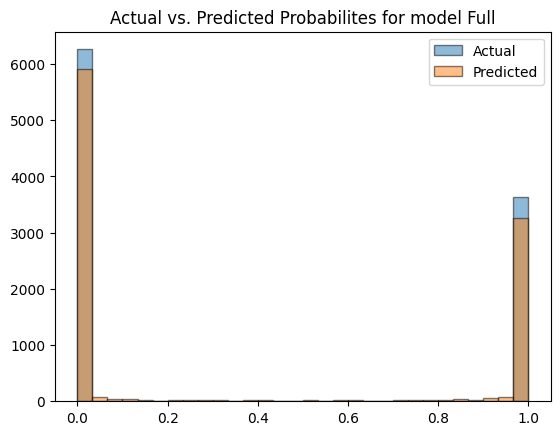

In [49]:
def model_fit_statistics (model_name, model) :
    model_results = {'model': model_name, 
                     'pr2': model.prsquared, 
                     'llf': model.llf, 
                     'llr': model.llr,
                     'llr-pvalue': model.llr_pvalue,
                     'aic': model.aic,
                     'bic': model.bic,
                     'pred-table': model.pred_table(0.05)}

    print('MODEL FIT METRICS:')
    print(f'PR2     = {model_results["pr2"]:.5f}')
    print(f'LLF     = {model_results["llf"]:.5f}')
    print(f'LLR     = {model_results["llr"]:.5f}')
    print(f'LLR-p   = {model_results["llr-pvalue"]:.5f}')
    print(f'AIC     = {model_results["aic"]:.5f}')
    print(f'BIC     = {model_results["bic"]:.5f}')

    # Plot probabilities actual vs fitted
    proba_actual = df[y]
    proba_fitted = model.predict()

    plt.hist(proba_actual, bins=30, alpha=0.5, edgecolor='black', label = 'Actual')
    plt.hist(proba_fitted, bins=30, alpha=0.5, edgecolor='black', label = 'Predicted')
    plt.legend(loc='upper right')
    plt.title(f'Actual vs. Predicted Probabilites for model {model_name}')
    plt.show()
    return model_results

mdl_full_results = model_fit_statistics('Full', mdl_full)

### Feature reduction

In [50]:
# Iteratively remove features with p-values above an acceptable value [In-Text Citation: (Vijayakumar, 2019)]
def backward_elimination(X, y, threshold_out, verbose=False):
    included=list(X.columns)

    while True:
        changed=False
        model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Drop {worst_feature:40} with p-value {worst_pval:.5f}')
        if not changed:
            break
    print(included)
    return X[included], included

tmp_df, X_reduced = backward_elimination(df[X_full], df[y], 0.05, True)
df_reduced = pd.concat([tmp_df, df[y]], axis=1) # Merge post feature reduction df with the target variable from the df
df_reduced.info()

Optimization terminated successfully.
         Current function value: 0.035140
         Iterations 14
Drop Service_Intravenous                      with p-value 0.97481
Optimization terminated successfully.
         Current function value: 0.035140
         Iterations 14
Drop Age                                      with p-value 0.90187
Optimization terminated successfully.
         Current function value: 0.035140
         Iterations 14
Drop Gender_Male                              with p-value 0.88154
Optimization terminated successfully.
         Current function value: 0.035142
         Iterations 14
Drop Full_meals_eaten                         with p-value 0.83151
Optimization terminated successfully.
         Current function value: 0.035144
         Iterations 14
Drop State                                    with p-value 0.81989
Optimization terminated successfully.
         Current function value: 0.035146
         Iterations 14
Drop Area                                     w

### Reduced model

In [51]:
# Construct reduced multiple linear regression model with no interactions
formula=f'{y} ~ '
first = True
for col in X_reduced :
    if first :
        first = False
    else :
        formula += ' + '
    formula += col

print(formula)
mdl_reduced = smf.logit(formula = formula, data = df).fit()
print(mdl_reduced.summary())

ReAdmis ~ Initial_days + Complication_risk + HighBlood + Stroke + Anxiety + Asthma + Service_CTScan + Service_MRI + Initial_EmergencyAdmission + Initial_ObservationAdmission
Optimization terminated successfully.
         Current function value: 0.036423
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:                ReAdmis   No. Observations:                 9891
Model:                          Logit   Df Residuals:                     9880
Method:                           MLE   Df Model:                           10
Date:                Sat, 22 Jun 2024   Pseudo R-squ.:                  0.9446
Time:                        15:59:48   Log-Likelihood:                -360.26
converged:                       True   LL-Null:                       -6501.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0

MODEL FIT METRICS:
PR2     = 0.94459
LLF     = -360.25876
LLR     = 12281.88911
LLR-p   = 0.00000
AIC     = 742.51752
BIC     = 821.71071


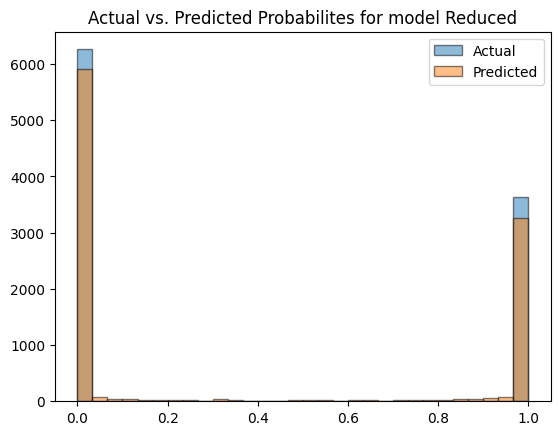

In [52]:
mdl_reduced_results = model_fit_statistics('Reduced', mdl_reduced)

### Model Comparison

╒═════════╤═════════╤════════════╤═════════════╤══════════════╤═══════════╤════════════╕
│ model   │     pr2 │        llf │         llr │   llr-pvalue │       aic │        bic │
╞═════════╪═════════╪════════════╪═════════════╪══════════════╪═══════════╪════════════╡
│ Full    │ 0.94654 │ -347.56547 │ 12307.27569 │      0.00000 │ 765.13094 │ 1017.10926 │
│ Reduced │ 0.94459 │ -360.25876 │ 12281.88911 │      0.00000 │ 742.51752 │  821.71071 │
╘═════════╧═════════╧════════════╧═════════════╧══════════════╧═══════════╧════════════╛


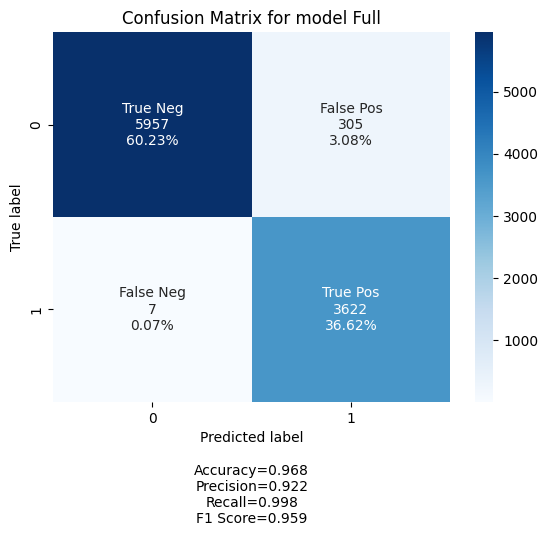

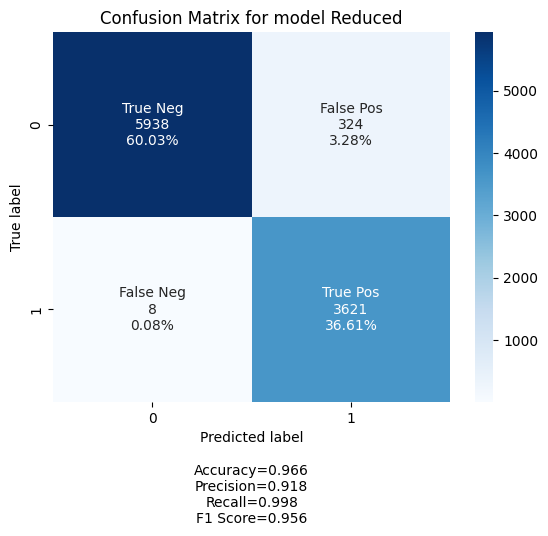

In [53]:
# [In-Text Citation (for using tabulate): (Astinin, 2022)]
# [In-Text Citation (for selecting only part of a dictionary): (Andrews, 2018)]

keys = ['model', 'pr2', 'llf', 'llr', 'llr-pvalue','aic','bic']
table_data = pd.DataFrame.from_dict([dict((key, mdl_full_results[key]) for key in keys), dict((key, mdl_reduced_results[key]) for key in keys)])
print(tabulate(table_data, headers="keys", tablefmt="fancy_outline", floatfmt=".5f", showindex=False))
make_confusion_matrix(mdl_full_results["pred-table"], group_names=group_names,title=f'Confusion Matrix for model {mdl_full_results["model"]}')
make_confusion_matrix(mdl_reduced_results["pred-table"], group_names=group_names,title=f'Confusion Matrix for model {mdl_reduced_results["model"]}')

plt.show()